# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-09-15 06:06:26--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  19.5MB/s    in 6.7s    

2023-09-15 06:06:33 (16.8 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

## Data Loading

In [3]:
data = io.loadmat('notMNIST_small.mat')

# data

In [4]:
x = data['images']
y = data['labels']

In [5]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [6]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [7]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

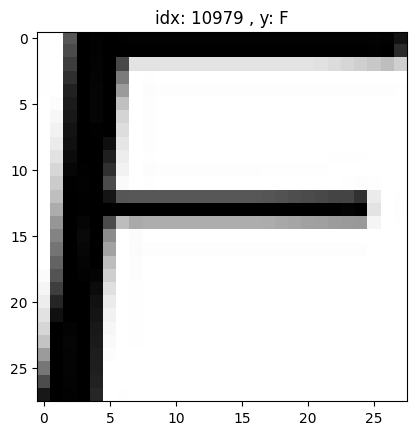

In [8]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='Greys' )
plt.show()

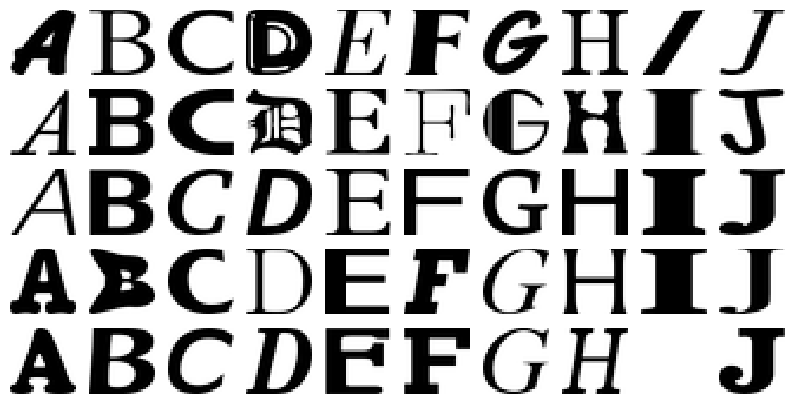

In [9]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='Greys', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split
    - training set : test set = 8 : 2
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2023

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2023)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2023)

In [12]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((11983, 28, 28, 1), (11983,), (2996, 28, 28, 1), (2996,))

* Scaling

    - min-max scaling

In [13]:
max_n, min_n = train_x.max(), train_x.min()
max_n, min_n

(255.0, 0.0)

In [14]:
train_x = (train_x - min_n) / (max_n - min_n)
val_x = (val_x - min_n) / (max_n - min_n)
test_x = (test_x - min_n) / (max_n - min_n)

In [15]:
train_x.max(), train_x.min()

(1.0, 0.0)

* One-hot encoding

In [16]:
train_y.shape

(11983,)

In [17]:
class_n = len(np.unique(train_y))
class_n

10

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
train_y = to_categorical(train_y, class_n)
val_y = to_categorical(val_y, class_n)
test_y = to_categorical(test_y, class_n)

* Data shape 재확인

In [20]:
train_x.shape, train_y.shape

((11983, 28, 28, 1), (11983, 10))

## **Image Data Augmentation**

- ImageDataGenerator : [**전체 옵션 참고**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- .flow( )

In [21]:
!mkdir output

In [22]:
!ls output

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
# 데이터 제너레이터를 선언함! 제너레이팅 규칙과 함께!
trainIDG = ImageDataGenerator(rescale=1./255,         # 사실 이 부분은 전처리 과정에서 했다.
                              zca_whitening=True,     # apply ZCA whitening
                              rotation_range=30,      # randomly rotate images in the range (degrees, 0 to 180)
                              zoom_range = 0.2,       # randomly zoom image
                              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,   # randomly flip images
                              vertical_flip=True)     # randomly flip images

# 옵션에 따라 필요할 수도 있고 그렇지 않을 수 있다.
trainIDG.fit(train_x)

# 학습 할 때마다, '실시간'으로 데이터를 생성하여 학습에 활용하고, 버리고를 반복할 준비!
flow_trainIDG = trainIDG.flow(train_x, train_y,
                              batch_size=128,
                            #   save_to_dir='output',
                            #   save_prefix='train',
                            #   save_format='png'
                              )

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [25]:
!ls output

In [26]:
valIDG = ImageDataGenerator(rescale=1./255)

flow_valIDG = valIDG.flow(val_x, val_y,           # validation set의 변수명!
                          batch_size=128,
                        #   save_to_dir='output',
                        #   save_prefix='val',
                        #   save_format='png'
                          )

## Modeling : CNN

- 조건
    1. Sequential API, Functional API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

In [27]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout

In [28]:
train_x.shape, train_y.shape

((11983, 28, 28, 1), (11983, 10))

In [30]:
## Functional API
# 1. 세션 클리어
clear_session()

# 2. 레이어 엮기
il = Input(shape=(28,28,1))

hl = Conv2D(filters=64,        # 새롭게 제작하려는 feature map의 수! 서로 다른 filter의 수!
            kernel_size=(3,3), # Conv 필터의 가로세로
            strides=(1,1),     # Conv 필터의 이동 보폭
            padding='same',    # 1. 사이즈 유지 | 2. 외곽 정보 더 반영
            activation='relu'  # 주의!
            )(il)
hl = Conv2D(filters=64,        # 새롭게 제작하려는 feature map의 수! 서로 다른 filter의 수!
            kernel_size=(3,3), # Conv 필터의 가로세로
            strides=(1,1),     # Conv 필터의 이동 보폭
            padding='same',    # 1. 사이즈 유지 | 2. 외곽 정보 더 반영
            activation='relu'  # 주의!
            )(hl)
hl = MaxPool2D(pool_size=(2,2), # 풀링 필터의 가로세로
               strides=(2,2)    # 풀링 필터의 이동 보폭
               )(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.5)(hl)

hl = Conv2D(filters=128,        # 새롭게 제작하려는 feature map의 수! 서로 다른 filter의 수!
            kernel_size=(3,3), # Conv 필터의 가로세로
            strides=(1,1),     # Conv 필터의 이동 보폭
            padding='same',    # 1. 사이즈 유지 | 2. 외곽 정보 더 반영
            activation='relu'  # 주의!
            )(hl)
hl = Conv2D(filters=128,        # 새롭게 제작하려는 feature map의 수! 서로 다른 filter의 수!
            kernel_size=(3,3), # Conv 필터의 가로세로
            strides=(1,1),     # Conv 필터의 이동 보폭
            padding='same',    # 1. 사이즈 유지 | 2. 외곽 정보 더 반영
            activation='relu'  # 주의!
            )(hl)
hl = MaxPool2D(pool_size=(2,2), # 풀링 필터의 가로세로
               strides=(2,2)    # 풀링 필터의 이동 보폭
               )(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.5)(hl)

hl = Flatten()(hl)
hl = Dense(1024, activation='relu')(hl)

ol = Dense(10, activation='softmax')(hl)

# 3. 모델의 시작과 끝 지정
model = Model(il, ol)

# 4. 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

* Early Stopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용 대상
                   min_delta=0,              # 임계값.
                   patience=3,               # 몇 번 더 지켜볼래.
                   verbose=1,
                   restore_best_weights=True # 최적의 가중치로 돌려줌.
                   )

* .fit( )
    - Image Data Augmentation 과정에서 생성한 ImageDataGenerator를 사용해야 한다.

In [35]:
model.fit(flow_trainIDG,               # 위에서 설정한 IDG를 사용해야 합니다!
          epochs=10000, verbose=1,
          validation_data=flow_valIDG, # validation data 역시 IDG를 사용해야 합니다.
          callbacks=[es]
          )

Epoch 1/10000
94/94 [==============================] - 29s 172ms/step - loss: 1.7398 - accuracy: 0.5190 - val_loss: 5.2281 - val_accuracy: 0.0988
Epoch 2/10000
94/94 [==============================] - 15s 158ms/step - loss: 0.8966 - accuracy: 0.7057 - val_loss: 4.6273 - val_accuracy: 0.0988
Epoch 3/10000
94/94 [==============================] - 15s 159ms/step - loss: 0.7712 - accuracy: 0.7480 - val_loss: 4.4361 - val_accuracy: 0.0895
Epoch 4/10000
94/94 [==============================] - 15s 158ms/step - loss: 0.6798 - accuracy: 0.7821 - val_loss: 6.2650 - val_accuracy: 0.0895
Epoch 5/10000
94/94 [==============================] - 15s 162ms/step - loss: 0.6313 - accuracy: 0.7995 - val_loss: 7.2511 - val_accuracy: 0.0895
Epoch 6/10000
94/94 [==============================] - 15s 161ms/step - loss: 0.5947 - accuracy: 0.8146 - val_loss: 9.2555 - val_accuracy: 0.0895
Epoch 6: early stopping


In [ ]:
!ls output

* .evaluate( )

In [36]:
model.evaluate(test_x, test_y)

118/118 [==============================] - 1s 5ms/step - loss: 3.2877 - accuracy: 0.3356


[3.2877118587493896, 0.3356475234031677]

* .predict( )

In [37]:
y_pred = model.predict(test_x)

118/118 [==============================] - 0s 3ms/step


In [38]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y, axis=1)

* 평가 지표

In [39]:
from sklearn.metrics import accuracy_score, classification_report

In [40]:
accuracy_score(test_y_arg, y_pred_arg)

0.33564753004005343

In [41]:
print( classification_report(test_y_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       0.20      0.94      0.33       357
           1       0.41      0.65      0.50       365
           2       0.00      0.00      0.00       374
           3       0.33      0.90      0.48       392
           4       1.00      0.00      0.00       406
           5       0.00      0.00      0.00       377
           6       0.81      0.60      0.69       372
           7       1.00      0.09      0.17       374
           8       0.57      0.19      0.28       385
           9       0.00      0.00      0.00       343

    accuracy                           0.34      3745
   macro avg       0.43      0.34      0.25      3745
weighted avg       0.44      0.34      0.25      3745



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualization

* 실제 데이터 확인

idx = 1312
해당 인덱스의 이미지는 E
모델의 예측 : B
모델의 클래스별 확률 : 
-------------------
A 5.0
B 40.0
C 0.0
D 1.0
E 16.0
F 0.0
G 14.0
H 0.0
I 21.0
J 0.0
땡


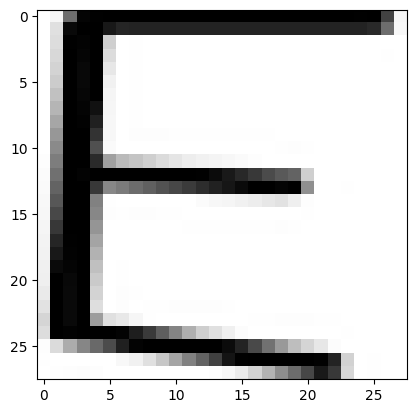

In [42]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='Greys')
plt.show()

* 틀린 이미지만 확인해보기

In [43]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

2488

idx = 2086
해당 인덱스의 이미지는 J
모델의 예측 : D
모델의 클래스별 확률 : 
-------------------
A 11.0
B 0.0
C 0.0
D 75.0
E 0.0
F 0.0
G 9.0
H 0.0
I 2.0
J 0.0
땡


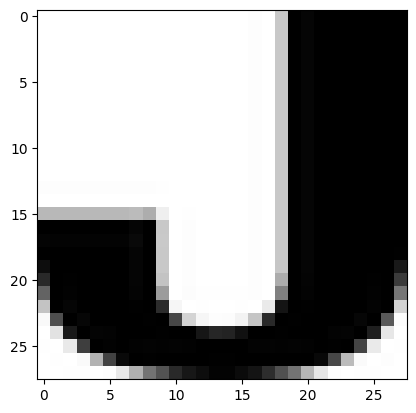

In [46]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='Greys')
plt.show()